# Diffusion Illusions: triangle puzzle

In [1]:
%%bash
if [ ! -d ".git" ]; then 
    rm -rf * .*; #Get rid of Colab's default junk files
    git clone -b master https://github.com/RyannDaGreat/Diffusion-Illusions .
fi

In [ ]:
%pip install --upgrade -r requirements.txt
%pip install rp --upgrade
# You may need to restart the runtime after installing these
# I'm not sure why this helps, but all sorts of weird random errors pop up in Colab if you don't

In [21]:
#SET YOUR PROMPTS HERE

prompt_a = "A orange cute kitten in a cardboard box in times square"
prompt_b = "photo of bunny hugging another bunny, dramatic light, pale sunrise, cinematic lighting"

NUMBER_OF_SQUARES = 4 # A 4x4 twisting squares illusion

#Optional: Specify what you DON'T want to see
negative_prompt = 'blurry ugly'

print()
print('Negative prompt:',repr(negative_prompt))
print()
print('Chosen prompts:')
print('    prompt_a =', repr(prompt_a)) #This will be right-side up
print('    prompt_b =', repr(prompt_b)) #This will be upside-down


Negative prompt: 'blurry ugly'

Chosen prompts:
    prompt_a = 'A orange cute kitten in a cardboard box in times square'
    prompt_b = 'photo of bunny hugging another bunny, dramatic light, pale sunrise, cinematic lighting'


In [ ]:
from rp import *
import numpy as np
import rp
import torch
import torch.nn as nn
import source.stable_diffusion as sd
from easydict import EasyDict
from source.learnable_textures import LearnableImageFourier
from source.stable_diffusion_labels import NegativeLabel
from itertools import chain
import time

device_count = torch.cuda.device_count()
print(f"Number of GPUs available: {device_count}")

/home/llt/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of GPUs available: 1


In [5]:
if 's' not in dir():
    #You can select the original Stable Diffusion 1.5 or some dreambooth of it
    model_name="./stable-diffusion-v1-4"
    # model_name="runwayml/stable-diffusion-v1-5"
    # model_name="nitrosocke/Arcane-Diffusion"
    gpu=rp.select_torch_device()
    s=sd.StableDiffusion(gpu,model_name)
device = s.device

WARNING! StableDiffusion was instantiated twice!
[INFO] sd.py: loading stable diffusion...please make sure you have run `huggingface-cli login`.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  8.93it/s]


[INFO] sd.py: loaded stable diffusion!


In [22]:
label_a = NegativeLabel(prompt_a,negative_prompt)
label_b = NegativeLabel(prompt_b,negative_prompt)

In [23]:
#Image Parametrization and Initialization (this section takes vram)

#Select Learnable Image Size (this has big VRAM implications!):
#Note: We use implicit neural representations for better image quality
#They're previously used in our paper "TRITON: Neural Neural Textures make Sim2Real Consistent" (see tritonpaper.github.io)
# ... and that representation is based on Fourier Feature Networks (see bmild.github.io/fourfeat)
learnable_image_maker = lambda: LearnableImageFourier(height=256,width=256,num_features=256,hidden_dim=256,scale=10).to(device);SIZE=256

image=learnable_image_maker()

In [12]:
import torch
import torch.nn.functional as F
import math

def get_perpendicular(vector):
    """
    Returns a vector perpendicular to the input 2D vector.
    For vector (x,y), returns (-y,x) which is rotated 90 degrees counterclockwise.
    """
    return torch.tensor([-vector[1], vector[0]], device=device)

def calculate_points(a):
    """
    Calculate all key points for the geometric construction.
    Args:
        a: side length of the square
    Returns:
        dict of points coordinates
    """
    # Convert inputs to torch tensors for consistent calculation
    a = torch.tensor(a, dtype=torch.float32, device=device)
    
    # Initial square points
    A = torch.tensor([a, 0.], device=device)
    B = torch.tensor([a, a], device=device)
    C = torch.tensor([0., a], device=device)
    D = torch.tensor([0., 0.], device=device)
    
    # Calculate P on CD
    DP_length = math.sqrt(math.sqrt(3)-1) * a
    DC_unit = (C - D) / torch.norm(C - D)
    P = D + DC_unit * DP_length
    
    # Calculate point E
    # BE parallel to AP, D,C,E collinear
    AP_vector = P - A
    AP_unit = AP_vector / torch.norm(AP_vector)
    BE_length = torch.norm(P - A)
    E = B + AP_unit * BE_length
    
    # Calculate point F (foot of perpendicular from B to AP)
    AF_length = torch.dot(B - A, AP_unit)
    F = A + AF_length * AP_unit
    
    # Calculate point G
    BF_vector = F - B
    G = B - BF_vector  # BG = BF
    
    # Calculate point K (intersection of FE and BC)
    BC_vector = C - B
    FE_vector = E - F
    # Use parametric equations to find intersection
    t = (torch.dot(B - F, get_perpendicular(BC_vector)) / torch.dot(FE_vector, get_perpendicular(BC_vector))).to(device)
    K = F + t * FE_vector
    
    # Calculate point M on BE
    BE_unit = (E - B) / torch.norm(E - B)
    M = B + BE_unit * AF_length
    
    # Calculate point N on GM
    GM_vector = M - G
    PD_length = torch.norm(P - D)
    N = G + (GM_vector / torch.norm(GM_vector)) * PD_length
    
    # Calculate point H
    EG_unit = (G - E) / torch.norm(G - E)
    H = E + EG_unit * torch.norm(F - K)

    DA_unit = (A - D) / torch.norm(A - D)
    NH_length = torch.norm(N - H)
    Q = D + DA_unit * NH_length

    translation = torch.tensor([-E[0], -F[1]], device=device)
    F1 = F + translation
    K1 = K + translation
    E1 = E + translation
    B1 = B + translation
    M1 = M + translation
    N1 = N + translation
    H1 = H + translation
    G1 = G + translation
    
    return {
        'A': A, 'B': B, 'C': C, 'D': D, 'E': E,
        'F': F, 'G': G, 'H': H, 'K': K, 'M': M,
        'N': N, 'P': P, 'Q': Q, 'F1': F1, 'K1': K1, 'E1': E1, 'B1': B1, 'M1': M1, 'N1': N1, 'H1': H1, 'G1': G1
    }

def create_region_masks(points, height, width):
    """
    Create binary masks for each region of the image
    """
    masks = {}
    
    # Create masks for each region using points
    # Triangle AQP
    masks['AQP'] = create_triangle_mask(points['A'], points['Q'], points['P'], height, width)
    
    # Triangle AFB
    masks['AFB'] = create_triangle_mask(points['A'], points['F'], points['B'], height, width)
    
    # Triangle DQP
    masks['DQP'] = create_triangle_mask(points['D'], points['Q'], points['P'], height, width)
    
    # Triangle KFB
    masks['KFB'] = create_triangle_mask(points['K'], points['F'], points['B'], height, width)

    # Triangle PCF
    masks['PCF'] = create_triangle_mask(points['P'], points['C'], points['F'], height, width)

    # Triangle CFK
    masks['CFK'] = create_triangle_mask(points['C'], points['F'], points['K'], height, width)
    
    return masks

def transform_regions(image, pad_source, points, masks):
    """
    Transform each region according to the geometric folding rules
    """
    output = torch.zeros_like(pad_source, device=device)
    
    # Transform each region
    # AQP -> B1K1E1
    transform_region(image, points['A'], points['Q'], points['P'],
                    points['B1'], points['K1'], points['E1'], output, masks['AQP'])
    
    # AFB -> M1B1G1
    transform_region(image, points['A'], points['F'], points['B'],
                    points['M1'], points['B1'], points['G1'], output, masks['AFB'])
    
    # DQP -> N1H1G1
    transform_region(image, points['D'], points['Q'], points['P'],
                    points['N1'], points['H1'], points['G1'], output, masks['DQP'])
    
    # KFB -> K1F1B1
    transform_region(image, points['K'], points['F'], points['B'],
                    points['K1'], points['F1'], points['B1'], output, masks['KFB'])
    
    # PCF -> M1N1E1
    transform_region(image, points['P'], points['C'], points['F'],
                    points['M1'], points['N1'], points['E1'], output, masks['PCF'])
    
    # # CFK -> N1E1H1
    transform_region(image, points['C'], points['F'], points['K'],
                    points['N1'], points['E1'], points['H1'], output, masks['CFK'])
      
    return output

def pad_image_to_size(image, target_height, target_width):
    pad_height = target_height - image.shape[-2]
    pad_width = target_width - image.shape[-1]
    
    return F.pad(image, (0, pad_height, 0, pad_width), mode='constant', value=0)

def create_triangle_mask(p1, p2, p3, height, width):
    """Create binary mask for triangle region"""
    mask = torch.zeros((height, width), device=device)
    
    # Convert points to pixel coordinates
    x = torch.tensor([p1[0], p2[0], p3[0]])
    y = torch.tensor([p1[1], p2[1], p3[1]])
    
    # Create grid
    grid_x, grid_y = torch.meshgrid(torch.arange(height, device=device),
                                   torch.arange(width, device=device))
    
    # Use barycentric coordinates to determine points inside triangle
    denom = (y[1] - y[2]) * (x[0] - x[2]) + (x[2] - x[1]) * (y[0] - y[2])
    alpha = ((y[1] - y[2]) * (grid_x - x[2]) + (x[2] - x[1]) * (grid_y - y[2])) / denom
    beta = ((y[2] - y[0]) * (grid_x - x[2]) + (x[0] - x[2]) * (grid_y - y[2])) / denom
    gamma = 1 - alpha - beta
    
    mask[(alpha >= 0) & (beta >= 0) & (gamma >= 0)] = 1
    mask = mask.bool()
    
    return mask

def normalize_points(points, H, W):
    return (points / torch.tensor([H-1, W-1], device=points.device)) * 2 - 1

def transform_region(image, p1, p2, p3, target_p1, target_p2, target_p3, output, mask):
    """Transform a triangular region to new position"""
    C, H, W = image.shape

    source = image * mask

    src_tri = normalize_points(torch.stack([p1, p2, p3]), H, W)
    dst_tri = normalize_points(torch.stack([target_p1, target_p2, target_p3]), H, W)

    # theta = torch.tensor([[1., 0., 0.], 
    #                       [0., 1., 0.]], device=device)

    theta = compute_affine_matrix(dst_tri, src_tri)[:2, :]

    coords_transformed = F.affine_grid(theta.unsqueeze(0), source.unsqueeze(0).size(), align_corners=True)  # [N, H, W, 2]

    # 找到 coords_transformed 中最小 x 坐标对应的点（若有多个，则再选最小 y）
    coords_transformed_flat = coords_transformed.view(-1, 2)  # 展平为 (N*H*W, 2)
    min_x_indices = torch.argmin(coords_transformed_flat[:, 0])
    min_x_coords = coords_transformed_flat[min_x_indices]
    coo = min_x_coords

    # 找到 dst_tri 中最小 x 坐标对应的点（若有多个，则再选最小 y）
    min_x_dst_tri = dst_tri[torch.argmin(dst_tri[:, 0])]
    p = min_x_dst_tri

    # translation = p - coo

    # coords_transformed += translation

    sample = F.grid_sample(source.unsqueeze(0), coords_transformed, mode="bilinear", align_corners=True).squeeze(0)  # [C, H, W]

    output.add_(sample)

def compute_affine_matrix(source_points, target_points):
    """Compute affine transformation matrix"""

    # [x y 1] * [a b c; d e f; 0 0 1] = [x' y' 1]
    
    A = torch.zeros((6, 6), device=device)
    b = torch.zeros(6, device=device)
    
    for i in range(3):
        x, y = source_points[i]
        x_prime, y_prime = target_points[i]
        
        A[i*2, 0] = y
        A[i*2, 1] = x
        A[i*2, 2] = 1
        b[i*2] = y_prime
        
        A[i*2+1, 3] = y
        A[i*2+1, 4] = x
        A[i*2+1, 5] = 1
        b[i*2+1] = x_prime
    
    solution = torch.linalg.solve(A, b)
    transform = solution.reshape(2, 3)
    transform = torch.cat([transform, torch.tensor([[0, 0, 1]], device=device)], dim=0)

    return transform

def geometric_folding_transform(image):
    """
    Main transformation function that converts square to triangle
    """
    pad_source = pad_image_to_size(image, 384, 384)
    C, H, W = image.shape
    C1, H1, W1 = pad_source.shape
    points = calculate_points(min(H, W))
    masks = create_region_masks(points, H1, W1)
    return transform_regions(pad_source, pad_source, points, masks)

print(calculate_points(256))

{'A': tensor([256.,   0.], device='cuda:0'), 'B': tensor([256., 256.], device='cuda:0'), 'C': tensor([  0., 256.], device='cuda:0'), 'D': tensor([0., 0.], device='cuda:0'), 'E': tensor([1.5259e-05, 4.7503e+02], device='cuda:0'), 'F': tensor([129.5409, 108.1983], device='cuda:0'), 'G': tensor([382.4590, 403.8017], device='cuda:0'), 'H': tensor([154.0967, 446.3335], device='cuda:0'), 'K': tensor([ 77.3476, 256.0000], device='cuda:0'), 'M': tensor([129.5409, 364.1983], device='cuda:0'), 'N': tensor([166.0624, 369.9171], device='cuda:0'), 'P': tensor([  0.0000, 219.0335], device='cuda:0'), 'Q': tensor([77.3476,  0.0000], device='cuda:0'), 'F1': tensor([129.5409,   0.0000], device='cuda:0'), 'K1': tensor([ 77.3475, 147.8017], device='cuda:0'), 'E1': tensor([  0.0000, 366.8352], device='cuda:0'), 'B1': tensor([256.0000, 147.8017], device='cuda:0'), 'M1': tensor([129.5409, 256.0000], device='cuda:0'), 'N1': tensor([166.0624, 261.7187], device='cuda:0'), 'H1': tensor([154.0967, 338.1351], devi

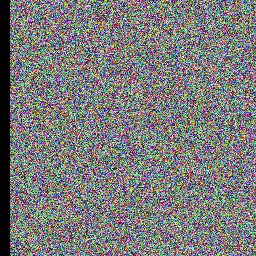

In [13]:
p1, p2, p3 = [10, 10], [20, 20], [0, 40] # 源三角形顶点
target_p1, target_p2, target_p3 = [10, 20], [20, 30], [0, 50] # 目标三角形顶点
p1 = torch.tensor(p1).to(device)
p2 = torch.tensor(p2).to(device)
p3 = torch.tensor(p3).to(device)
target_p1 = torch.tensor(target_p1).to(device)
target_p2 = torch.tensor(target_p2).to(device)
target_p3 = torch.tensor(target_p3).to(device)

source_img = torch.rand(3, 256, 256).to(device)
output = torch.zeros((3,256,256)).to(device)
mask = torch.ones_like(output).to(device)
transform_region(source_img,p1,p2,p3,target_p1,target_p2,target_p3,output,mask)
rp.display_image(output)

In [24]:
learnable_image_a=lambda: image()
learnable_image_b=lambda: geometric_folding_transform(image())

optim=torch.optim.SGD(image.parameters(),lr=1e-4)

In [25]:
labels=[label_a,label_b]
learnable_images=[learnable_image_a,learnable_image_b]

#The weight coefficients for each prompt. For example, if we have [0,1], then only the upside-down mode will be optimized
weights=[1,1]

weights=rp.as_numpy_array(weights)
weights=weights/weights.sum()
weights=weights*len(weights)

In [26]:
#For saving a timelapse
ims=[]

In [27]:
def get_display_image():
    return rp.tiled_images(
        [
            rp.as_numpy_image(learnable_image_a()),
            rp.as_numpy_image(learnable_image_b()),
        ],
        length=len(learnable_images),
        border_thickness=0,
    )

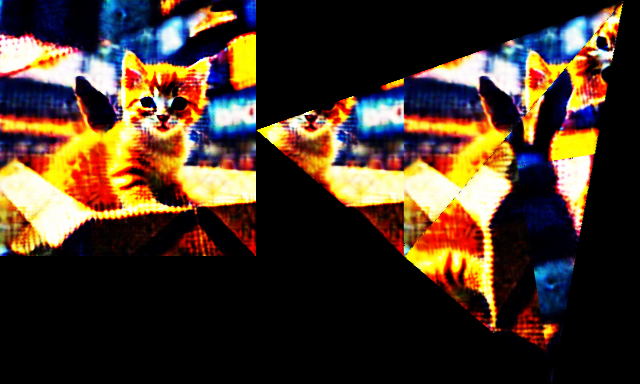

Every 200 iterations we display an image in the form [image_a, image_b], where
    image_a = (the right-side up image)
    image_b = (image_a, but upside down)

Interrupt the kernel at any time to return the currently displayed image
You can run this cell again to resume training later on

Please expect this to take quite a while to get good images (especially on the slower Colab GPU's)! The longer you wait the better they'll be


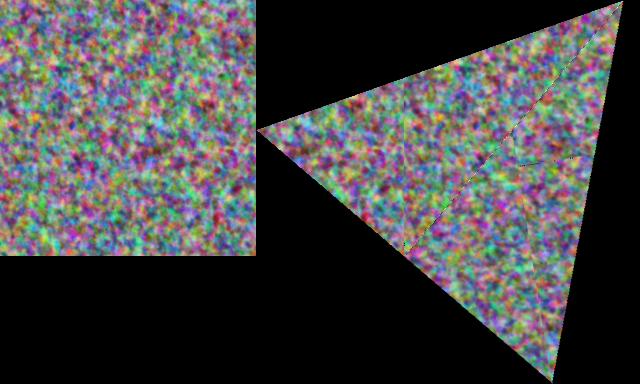

Status: ETR=0:12:35.904173	ETA=0:13:07.400180	T=0:00:31.496007	Progress: 200/5000

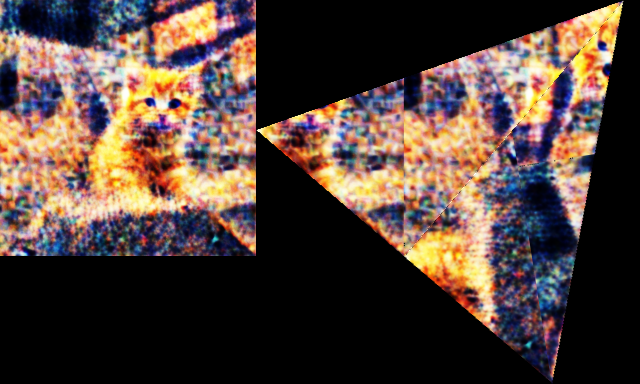

Status: ETR=0:12:03.344235	ETA=0:13:06.243734	T=0:01:02.899499	Progress: 400/5000

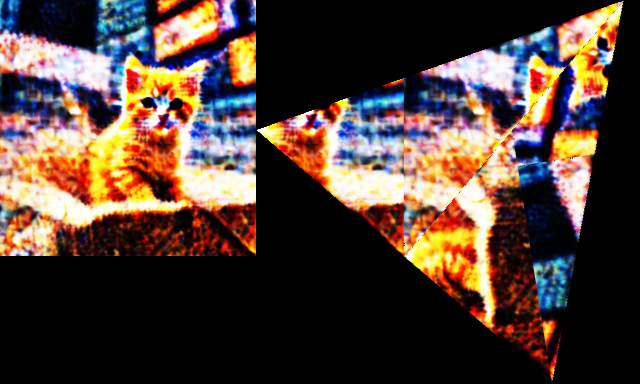

Status: ETR=0:11:32.390106	ETA=0:13:06.628160	T=0:01:34.238054	Progress: 599/5000

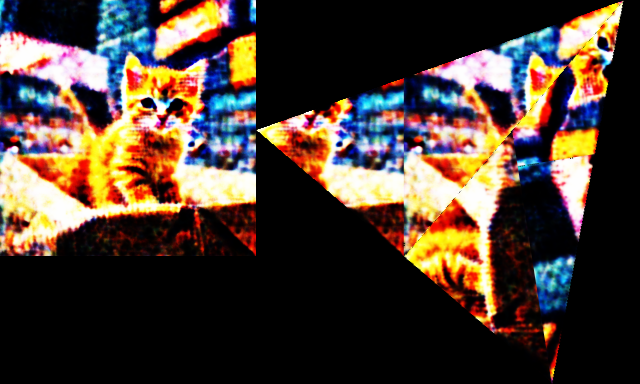

Status: ETR=0:11:00.961356	ETA=0:13:06.671455	T=0:02:05.710099	Progress: 799/5000

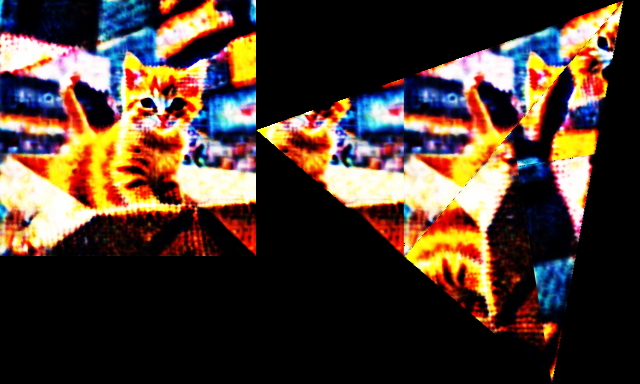

Status: ETR=0:10:29.700409	ETA=0:13:07.125511	T=0:02:37.425102	Progress: 1000/5000

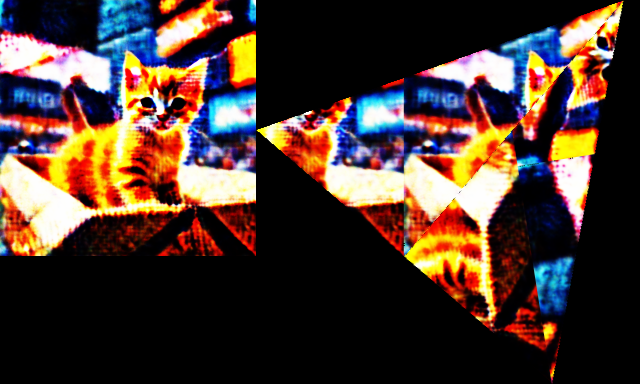

Status: ETR=0:09:58.065192	ETA=0:13:06.927884	T=0:03:08.862692	Progress: 1200/5000

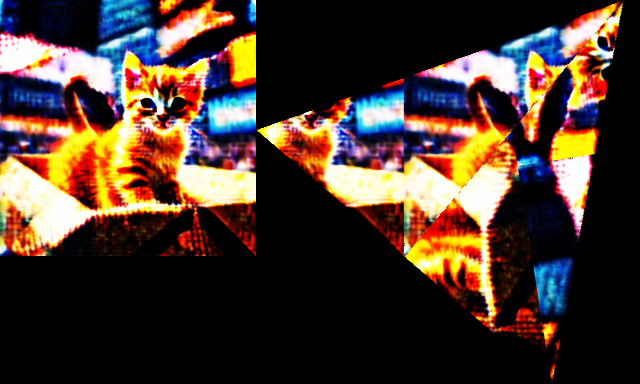

Status: ETR=0:09:26.517418	ETA=0:13:06.829747	T=0:03:40.312329	Progress: 1400/5000

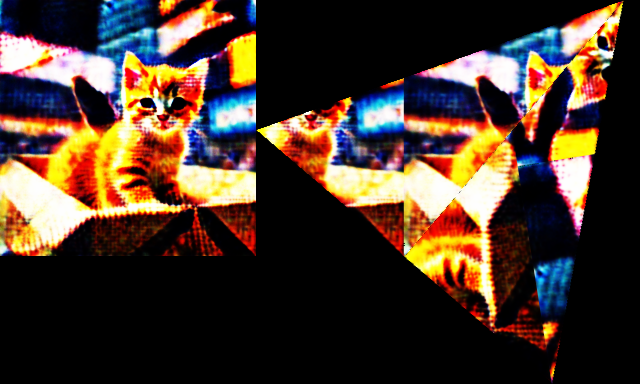

Status: ETR=0:08:54.872729	ETA=0:13:06.577542	T=0:04:11.704813	Progress: 1600/5000

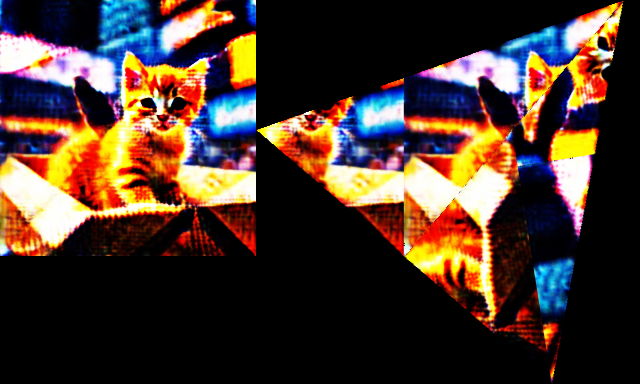

Status: ETR=0:08:23.426137	ETA=0:13:06.603340	T=0:04:43.177202	Progress: 1800/5000

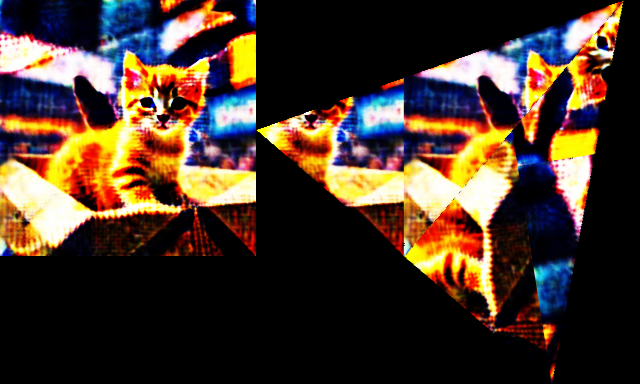

Status: ETR=0:07:51.916251	ETA=0:13:06.527085	T=0:05:14.610834	Progress: 2000/5000

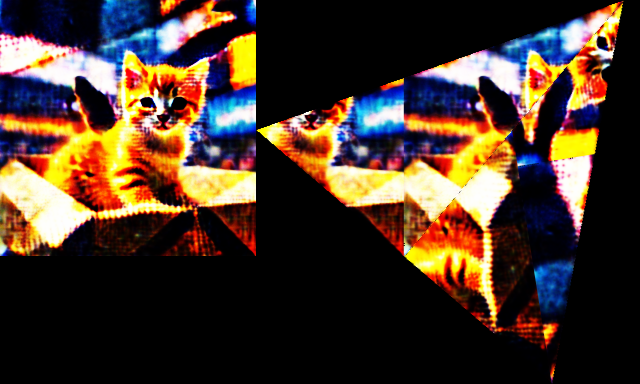

Status: ETR=0:07:20.464168	ETA=0:13:06.543158	T=0:05:46.078990	Progress: 2200/5000

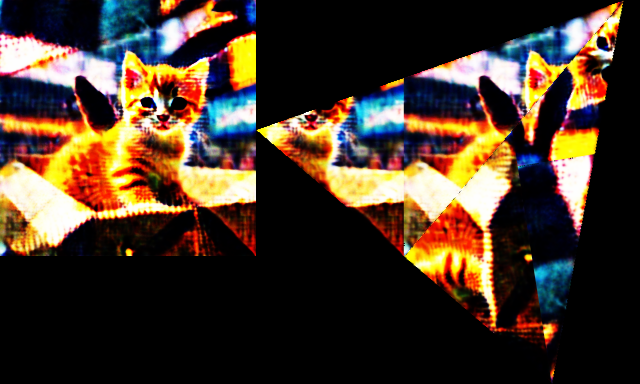

Status: ETR=0:06:49.211580	ETA=0:13:06.642792	T=0:06:17.431211	Progress: 2399/5000

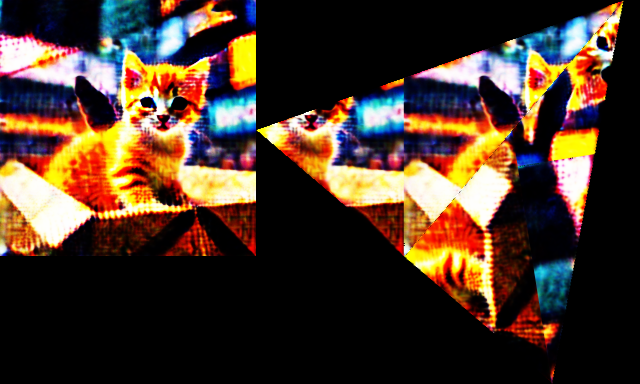

Status: ETR=0:06:17.717731	ETA=0:13:06.911939	T=0:06:49.194208	Progress: 2600/5000

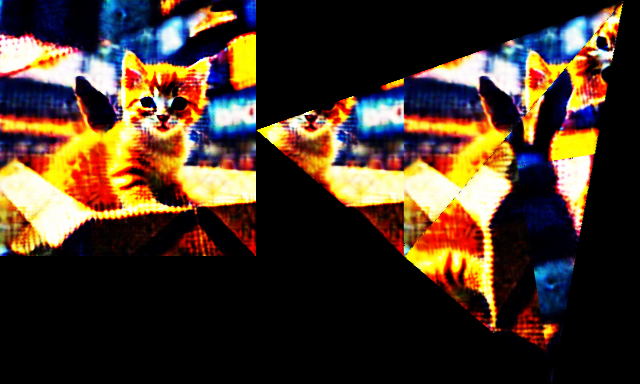

Status: ETR=0:06:13.521105	ETA=0:13:07.022978	T=0:06:53.501873	Progress: 2627/5000
Interrupted early at iteration 2627


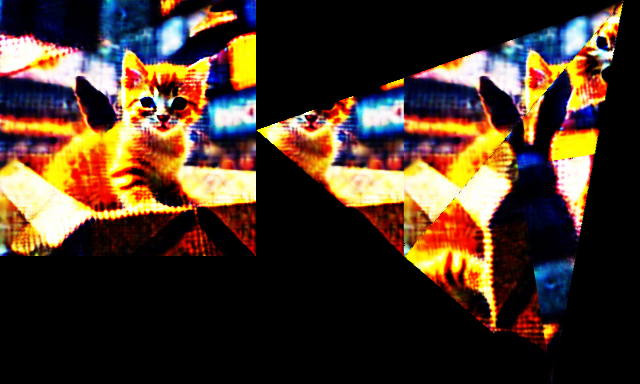

In [28]:
NUM_ITER=5000

#Set the minimum and maximum noise timesteps for the dream loss (aka score distillation loss)
s.max_step=MAX_STEP=990
s.min_step=MIN_STEP=10 

television = rp.JupyterDisplayChannel()
television.display()

display_eta=rp.eta(NUM_ITER, title='Status')

DISPLAY_INTERVAL = 200

print('Every %i iterations we display an image in the form [image_a, image_b], where'%DISPLAY_INTERVAL)
print('    image_a = (the right-side up image)')
print('    image_b = (image_a, but upside down)')
print()
print('Interrupt the kernel at any time to return the currently displayed image')
print('You can run this cell again to resume training later on')
print()
print('Please expect this to take quite a while to get good images (especially on the slower Colab GPU\'s)! The longer you wait the better they\'ll be')

try:
    for iter_num in range(NUM_ITER):
        display_eta(iter_num) #Print the remaining time

        preds=[]
        for label,learnable_image,weight in rp.random_batch(list(zip(labels,learnable_images,weights)), batch_size=1):
            pred=s.train_step(
                label.embedding,
                learnable_image()[None],

                #PRESETS (uncomment one):
                noise_coef=.1*weight,guidance_scale=100,#10
                # noise_coef=0,image_coef=-.01,guidance_scale=50,
                # noise_coef=0,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1,image_coef=-.010,guidance_scale=50,
                # noise_coef=.1,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1*weight, image_coef=-.005*weight, guidance_scale=50,
            )
            preds+=list(pred)

        with torch.no_grad():
            if iter_num and not iter_num%(DISPLAY_INTERVAL*50):
                #Wipe the slate every 50 displays so they don't get cut off
                from IPython.display import clear_output
                clear_output()

            if not iter_num%(DISPLAY_INTERVAL//4):
                im = get_display_image()
                ims.append(im)
                television.update(im)
                
                if not iter_num%DISPLAY_INTERVAL:
                    rp.display_image(im)

        optim.step()
        optim.zero_grad()
except KeyboardInterrupt:
    print()
    print('Interrupted early at iteration %i'%iter_num)
    im = get_display_image()
    ims.append(im)
    rp.display_image(im)

Unsolved Image:


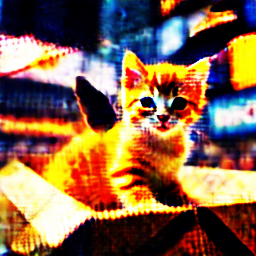

Solved Image:


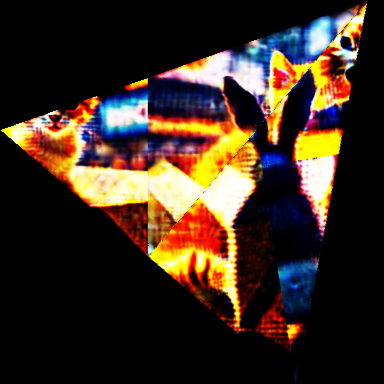

In [29]:
print('Unsolved Image:')
rp.display_image(rp.as_numpy_image(learnable_image_a()))

print('Solved Image:')
rp.display_image(rp.as_numpy_image(learnable_image_b()))

In [30]:
def save_run(name):
    folder="untracked/triangle_puzzle_runs/%s"%name
    if rp.path_exists(folder):
        folder+='_%i'%time.time()
    rp.make_directory(folder)
    ims_names=['ims_%04i.png'%i for i in range(len(ims))]
    with rp.SetCurrentDirectoryTemporarily(folder):
        rp.save_images(ims,ims_names,show_progress=True)
    print()
    print('Saved timelapse to folder:',repr(folder))
    
save_run('-'.join([prompt_a,prompt_b])) #You can give it a good custom name if you want!

Saving Images: COMPLETED IN 0:00:00.312870	Progress: 54/54
rp.save_images: Done! Saved 54 images in 0.315 seconds

Saved timelapse to folder: 'untracked/triangle_puzzle_runs/A orange cute kitten in a cardboard box in times square-photo of bunny hugging another bunny, dramatic light, pale sunrise, cinematic lighting'
